## Unmatched sample analysis

This notebook contains a short analysis on the matched sample. 

The datasets can be retrieved by running `data_to_analysis_unmatched.ipynb`. 

In [83]:
# Load libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.compat import lzip

In [84]:
# Regression discontinuity package
from rdd import rdd

In [85]:
def to_float(x):
    try:
        return float(x)
    except:
        return None

In [91]:
pd.set_option('display.max_rows', 15)

unmatched_sample = pd.read_csv("../Data/analysis/unmatched_sample_analysis.csv", dtype={'b1-nummer':str}).iloc[:,1:]

unmatched_sample['Vermogen'] = unmatched_sample['Vermogen_deflated'].apply(lambda x: to_float(x))
unmatched_sample['logVermogen'] = np.log(1+unmatched_sample['Vermogen_deflated'])

/Users/basmachielsen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='margin', ylabel='Vermogen'>

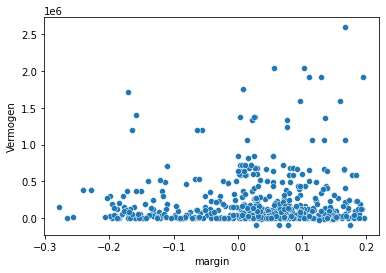

In [92]:
sns.scatterplot(data = unmatched_sample,
               x = 'margin',
               y = 'Vermogen')

<AxesSubplot:xlabel='margin', ylabel='logVermogen'>

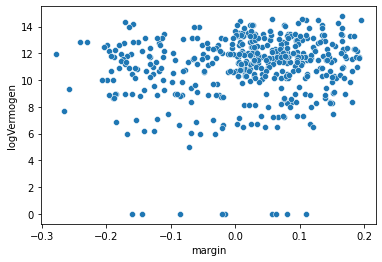

In [93]:
sns.scatterplot(data = unmatched_sample,
               x = 'margin',
               y = 'logVermogen')

## Short RDD Analysis (Preliminary)

We first calculate the Imbens & Kalyanaraman (2012) optimal bandwidth, then filter the data accordingly. 

Then, we plot the discontinuity in actual data, then in bins. 

In [94]:
threshold = 0 
bandwidth_opt = rdd.optimal_bandwidth(unmatched_sample['Vermogen'], unmatched_sample['margin'], cut=threshold)

In [95]:
data_rdd = rdd.truncated_data(unmatched_sample, 'margin', bandwidth_opt, cut=threshold)

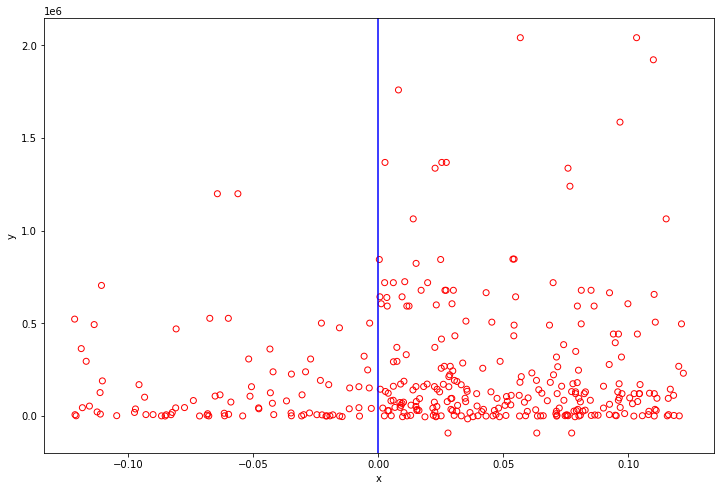

In [97]:
plt.figure(figsize=(12, 8))
plt.scatter(data_rdd['margin'], data_rdd['Vermogen'], facecolors='none', edgecolors='r')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(x=threshold, color='b')
plt.show()
plt.close()

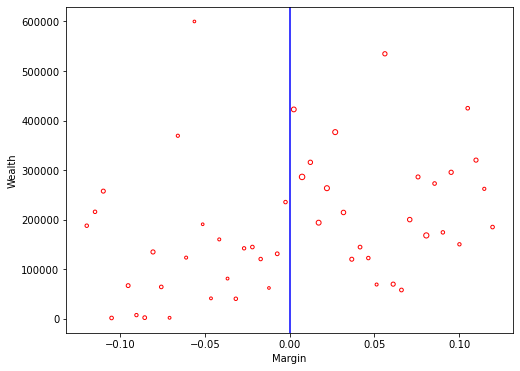

In [98]:
data_binned = rdd.bin_data(data_rdd, 'Vermogen', 'margin', 50)

plt.figure(figsize=(8,6))
plt.scatter(data_binned['margin'], data_binned['Vermogen'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')
plt.xlabel('Margin')
plt.ylabel('Wealth')
plt.show()
plt.close()

## Second step

We repeat this analysis using log(Vermogen).

In [99]:
threshold = 0 
bandwidth_opt = rdd.optimal_bandwidth(unmatched_sample['logVermogen'], unmatched_sample['margin'], cut=threshold)

In [100]:
data_rdd = rdd.truncated_data(unmatched_sample, 'margin', bandwidth_opt, cut=threshold)

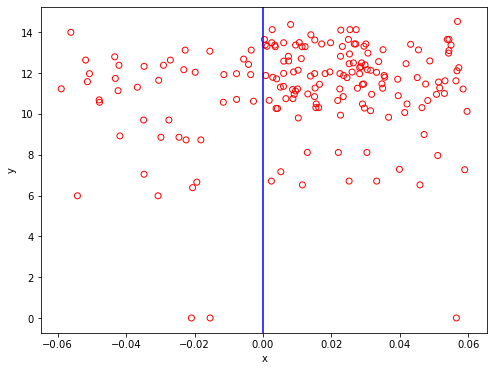

In [109]:
plt.figure(figsize=(8, 6))
plt.scatter(data_rdd['margin'], data_rdd['logVermogen'], facecolors='none', edgecolors='r')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(x=threshold, color='b')
plt.show()
plt.close()

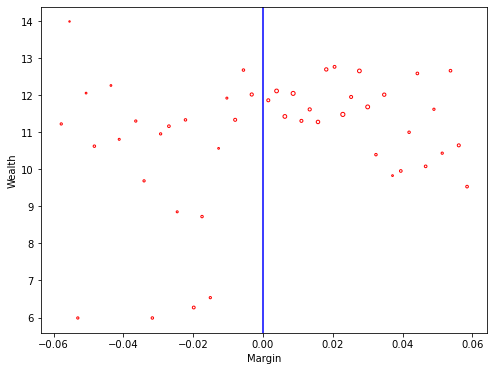

In [108]:
data_binned = rdd.bin_data(data_rdd, 'logVermogen', 'margin', 50)

plt.figure(figsize=(8,6))
plt.scatter(data_binned['margin'], data_binned['logVermogen'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')
plt.xlabel('Margin')
plt.ylabel('Wealth')
plt.show()
plt.close()

## Statistical results

Firstly, we just use OLS, no polynomials etc. 

In [103]:
model = rdd.rdd(data_rdd, 'margin', 'logVermogen', cut=threshold)
print(model.fit().summary())

Estimation Equation:	 logVermogen ~ TREATED + margin
                            WLS Regression Results                            
Dep. Variable:            logVermogen   R-squared:                       0.063
Model:                            WLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     5.890
Date:                Wed, 12 May 2021   Prob (F-statistic):            0.00334
Time:                        17:30:37   Log-Likelihood:                -404.05
No. Observations:                 179   AIC:                             814.1
Df Residuals:                     176   BIC:                             823.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [104]:
print(model.fit(cov_type='hc1').summary())

                            WLS Regression Results                            
Dep. Variable:            logVermogen   R-squared:                       0.063
Model:                            WLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     3.850
Date:                Wed, 12 May 2021   Prob (F-statistic):             0.0231
Time:                        17:30:56   Log-Likelihood:                -404.05
No. Observations:                 179   AIC:                             814.1
Df Residuals:                     176   BIC:                             823.7
Df Model:                           2                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8183      0.622     15.776      0.0

## Placebo tests

Change the threshold to see if we still get results (we should get much smaller or no effect)

In [105]:
for i in [-0.1, -0.075, -0.05, -0.025, 0.0, 0.025, 0.05, 0.075]:
    data_placebo = rdd.truncated_data(unmatched_sample, 'margin', yname='logVermogen', cut=i)
    model = rdd.rdd(data_placebo, 'margin', 'logVermogen', cut=i)
    print("############# \n"*4, "Treatment effect at margin=", i, "\n #############" *4)
    print(model.fit().summary())

Estimation Equation:	 logVermogen ~ TREATED + margin
############# 
############# 
############# 
############# 
 Treatment effect at margin= -0.1 
 #############
 #############
 #############
 #############
                            WLS Regression Results                            
Dep. Variable:            logVermogen   R-squared:                       0.011
Model:                            WLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.5710
Date:                Wed, 12 May 2021   Prob (F-statistic):              0.567
Time:                        17:31:11   Log-Likelihood:                -261.56
No. Observations:                 108   AIC:                             529.1
Df Residuals:                     105   BIC:                             537.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
  